In [ ]:
# Tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# Sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Keras
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Data

In [ ]:
# Open the zip file
zip_file_path = '/content/archive.zip'
extract_to_path = './'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [ ]:
# Load data
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')
data_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [ ]:
print('Clases:', data_train['Activity'].unique())

Clases: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


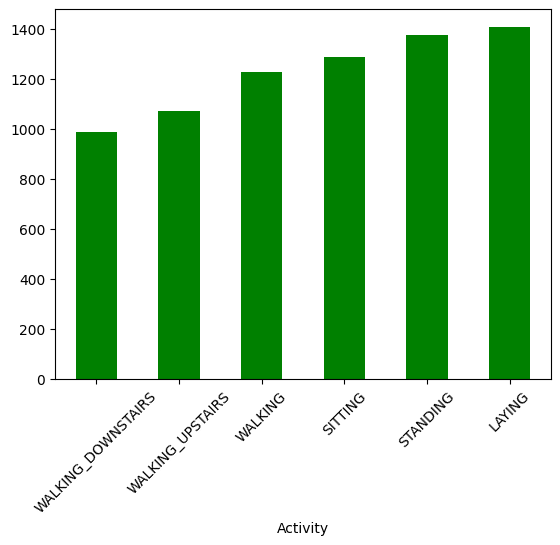

In [ ]:
data_train['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'green')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Prepare data
x_train, y_train = data_train.iloc[:, :-2], data_train.iloc[:, -1:]
x_test, y_test   = data_test.iloc[:, :-2], data_test.iloc[:, -1:]

le = LabelEncoder()
y_train = le.fit_transform(y_train.iloc[:,0])
y_test  = le.fit_transform(y_test.iloc[:,0])

# Scale data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print('Tamaño del conjunto de entrenamiento: ', len(x_train))
print('Tamaño del conjunto de test.        : ', len(x_test))

Tamaño del conjunto de entrenamiento:  7352
Tamaño del conjunto de test.        :  2947


## Breve exploración

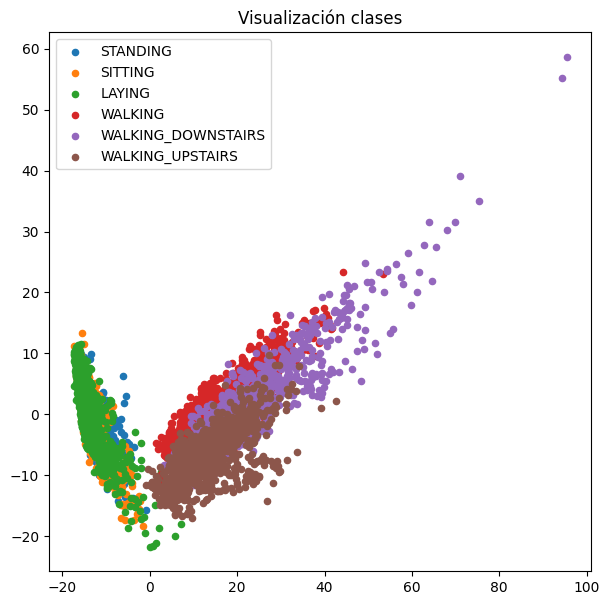

In [ ]:
# Apply PCA
scaler         = StandardScaler()
pca            = PCA(n_components=2)
data_transform = pca.fit_transform(x_train_scaled)

# Visualize
plt.figure(figsize=(7, 7))
for activity in data_train['Activity'].unique():
    labels = data_train['Activity'] == activity
    plt.scatter(data_transform[labels, 0], data_transform[labels, 1], label=str(activity), marker='o', s=20)
    plt.legend()

plt.title('Visualización clases')
plt.show()

## Modelo y entrenamiento

In [ ]:
# Hacemos reshape a los datos
x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], 1, x_train_scaled.shape[1])
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])

# Creamos el modelo
model = Sequential([
    SimpleRNN(50, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2]), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(50),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
history = model.fit(x_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(x_test_reshaped, y_test))

# Evaluamos el modelo
loss, accuracy = model.evaluate(x_test_reshaped, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
115/115 [==============================] - 5s 15ms/step - loss: 0.8784 - accuracy: 0.6446 - val_loss: 0.3142 - val_accuracy: 0.8738
Epoch 2/10
115/115 [==============================] - 1s 10ms/step - loss: 0.3719 - accuracy: 0.8618 - val_loss: 0.1907 - val_accuracy: 0.9270
Epoch 3/10
115/115 [==============================] - 1s 13ms/step - loss: 0.2648 - accuracy: 0.9087 - val_loss: 0.1577 - val_accuracy: 0.9420
Epoch 4/10
115/115 [==============================] - 1s 10ms/step - loss: 0.1924 - accuracy: 0.9325 - val_loss: 0.1480 - val_accuracy: 0.9437
Epoch 5/10
115/115 [==============================] - 1s 7ms/step - loss: 0.1527 - accuracy: 0.9514 - val_loss: 0.1390 - val_accuracy: 0.9481
Epoch 6/10
115/115 [==============================] - 1s 7ms/step - loss: 0.1323 - accuracy: 0.9527 - val_loss: 0.1448 - val_accuracy: 0.9481
Epoch 7/10
115/115 [==============================] - 1s 6ms/step - loss: 0.1184 - accuracy: 0.9596 - val_loss: 0.1526 - val_accuracy: 0.9464
Ep

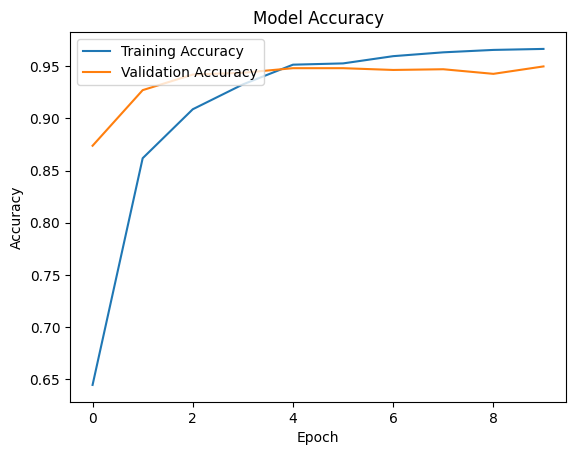

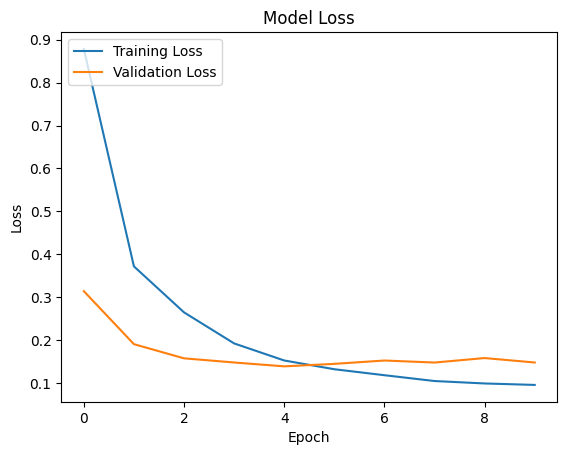

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


93/93 [==============================] - 0s 3ms/step


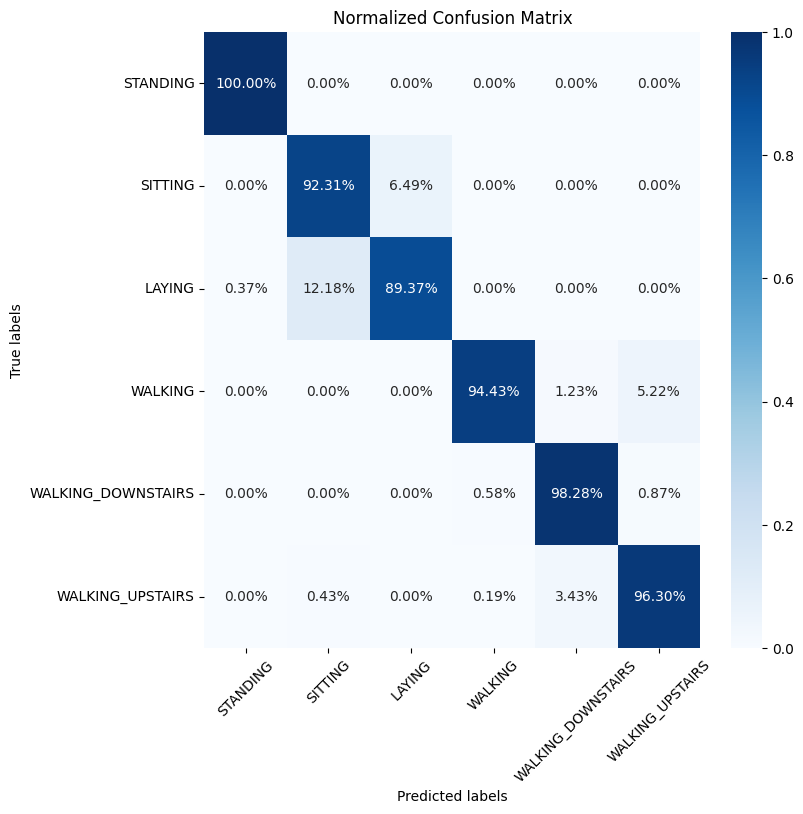

In [ ]:
# Matriz de confusión
y_pred_probs = model.predict(x_test_reshaped)
y_pred       = np.argmax(y_pred_probs, axis=1)

confusion_matrix_     = confusion_matrix(y_pred, y_test)
confusion_matrix_norm = confusion_matrix_ / confusion_matrix_.sum(axis=1)

# Display as heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_norm, annot=True,
            xticklabels=data_test['Activity'].unique(),
            yticklabels=data_test['Activity'].unique(),
            fmt='.2%', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45)
plt.show()